Import the libraries
-----------

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from ydata_profiling import ProfileReport
import optuna
from tqdm.auto import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import datetime
import os

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


Using Ydata profilng dor dataset overview (attached as a separate html file)
--------------

In [6]:
df = pd.read_csv('train.csv')
'''profile = ProfileReport(
        train, title="mushrooms_profile", explorative=True, dark_mode=True
    )
profile.to_file("mushrooms_profile.html")'''

'profile = ProfileReport(\n        train, title="mushrooms_profile", explorative=True, dark_mode=True\n    )\nprofile.to_file("mushrooms_profile.html")'

While preparing data we just replace all unfrequent categorical values by 'unknown'
-------------------

In [7]:
def data_prepatation(df):
    data = df.copy()
    data['spore-print-color'] = data['spore-print-color'].apply(lambda x: x if x in ['k', 'p', 'w', 'n', 'r', 'u', 'g'] else 'other')
    data['cap-shape'] = data['cap-shape'].fillna('unknown')
    data['cap-shape'] = data['cap-shape'].apply(lambda x: x if x in  ['unknown', 'x', 'f', 's', 'b', 'o', 'p', 'c'] else 'other')
    data['cap-surface'] = data['cap-surface'].fillna('unknown')
    data['cap-surface'] = data['cap-surface'].apply(lambda x: x if x in ['unknown','t', 's', 'y', 'h', 'g', 'd', 'k', 'e', 'i', 'w', 'l'] else 'other')
    data['cap-color'] = data['cap-color'].fillna('unknown')
    data['cap-color'] = data['cap-color'].apply(lambda x: x if x in  ['unknown','n', 'y', 'w', 'g', 'e', 'o', 'p', 'r', 'u', 'b', 'k', 'l'] else 'other')
    data['does-bruise-or-bleed'] = data['does-bruise-or-bleed'].fillna('unknown')
    data['does-bruise-or-bleed'] = data['does-bruise-or-bleed'].apply(lambda x: x if x in  ['unknown','f','t'] else 'other')
    data['gill-attachment'] = data['gill-attachment'].fillna('unknown')
    data['gill-attachment'] = data['gill-attachment'].apply(lambda x: x if x in ['unknown','a', 'd', 'x', 'e', 's', 'p', 'f'] else 'other')
    data.drop('gill-spacing', axis=1, inplace=True)
    data.drop('stem-surface', axis=1, inplace=True)
    data['gill-color'] = data['gill-color'].fillna('unknown')
    data['gill-color'] = data['gill-color'].apply(lambda x: x if x in ['unknown','w', 'n', 'y', 'p', 'g', 'o', 'k', 'f', 'r', 'e', 'b', 'u'] else 'other')
    data['stem-root'] = data['stem-root'].fillna('unknown')
    data['stem-root'] = data['stem-root'].apply(lambda x: x if x in ['unknown','b', 's', 'r', 'c'] else 'other')
    data['stem-color'] = data['stem-color'].fillna('unknown')
    data['stem-color'] = data['stem-color'].apply(lambda x: x if x in ['unknown','w', 'n', 'y', 'g', 'o', 'e', 'u', 'p', 'k', 'r', 'l', 'b'] else 'other')
    data.drop('veil-type', axis=1, inplace=True)
    data['veil-color'] = data['veil-color'].fillna('unknown')
    data['veil-color'] = data['veil-color'].apply(lambda x: x if x in ['unknown','w', 'y', 'n', 'u', 'k', 'e'] else 'other')
    data['has-ring'] = data['has-ring'].fillna('unknown')
    data['has-ring'] = data['has-ring'].apply(lambda x: x if x in  ['unknown','f','t'] else 'other')
    data.drop('ring-type', axis=1, inplace=True)
    data.drop('id', axis=1, inplace=True)
    data.drop('spore-print-color', axis=1, inplace=True)
    data['habitat'] = data['habitat'].fillna('unknown')
    data['habitat'] = data['habitat'].apply(lambda x: x if x in  ['unknown','d', 'g', 'l', 'm', 'h', 'w', 'p', 'u'] else 'other')
    diameter_cap = data['cap-diameter'].mode()[0]
    data['cap-diameter'] = data['cap-diameter'].fillna(diameter_cap)
    stem_cap = data['stem-height'].mode()[0]
    data['stem-height'] = data['stem-height'].fillna(stem_cap)
        
    return data

The function to indicate frequent values, used in data preparation
-----------------

In [6]:
'''value_counts = train['habitat'].value_counts()
value_counts[value_counts >= 1000].index'''

"value_counts = train['habitat'].value_counts()\nvalue_counts[value_counts >= 1000].index"

In [8]:
df = data_prepatation(df)

In [9]:
X,y = df.drop('class', axis=1), df['class'].apply(lambda x: 0 if x == 'e' else 1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
objects = ['object','category', 'bool']
cat_features = Xtrain.select_dtypes(include=objects).columns.tolist()

numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = Xtrain.select_dtypes(include=numerics).columns.tolist()

print(f'numeric={num_features}\ncats={cat_features}')

numeric=['cap-diameter', 'stem-height', 'stem-width']
cats=['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-root', 'stem-color', 'veil-color', 'has-ring', 'habitat', 'season']


No standartisation, because we are using boosters (based on trees methods) to predict
--------------------

In [39]:
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
preprocessor = ColumnTransformer(transformers=[
    #("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

Preparing table with results
----------------

In [20]:
stat = pd.DataFrame(columns=['model', 'params', 'learning_time', 'train_auc_score', 'test_auc_score', 'cv_mean_score',	'cv_std'])

Modeling
---------------

In [21]:
models_basic_params = [LGBMClassifier(), CatBoostClassifier(), XGBClassifier()]
modnames = ['LGBMC', 'CB', 'XGBC']

In [22]:
for i in tqdm(range(len(models_basic_params)), desc="Progress"):
    model = Pipeline(steps=[("preprocessor",preprocessor),
                            ("classifier", models_basic_params[i])
                        ])
    start = datetime.datetime.now()
    model.fit(Xtrain, ytrain)
    learning_time = str(datetime.datetime.now() - start)
    predtrain = model.predict_proba(Xtrain)
    predtest = model.predict_proba(Xtest)
    score_train = roc_auc_score(ytrain, predtrain[:,1])
    score_test = roc_auc_score(ytest, predtest[:,1])
    
    res = pd.DataFrame({
        'model': modnames[i],
        'params': 'basic',
        'learning_time': [learning_time],
        'train_auc_score': [score_train],
        'test_auc_score': [score_test], 
        'cv_mean_score': '-',
        'cv_std': '-'})
    
    stat = pd.concat([stat, res]).reset_index(drop=True)

Progress:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ESC\AppData\Local\Temp\ipykernel_10768\1784247058.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stat = pd.concat([stat, res]).reset_index(drop=True)


Learning rate set to 0.290654
0:	learn: 0.6127162	total: 394ms	remaining: 6m 34s
1:	learn: 0.5488075	total: 731ms	remaining: 6m 4s
2:	learn: 0.4854097	total: 1.07s	remaining: 5m 57s
3:	learn: 0.4509452	total: 1.42s	remaining: 5m 53s
4:	learn: 0.4165863	total: 1.75s	remaining: 5m 49s
5:	learn: 0.3949049	total: 2.09s	remaining: 5m 46s
6:	learn: 0.3718763	total: 2.45s	remaining: 5m 47s
7:	learn: 0.3566870	total: 2.79s	remaining: 5m 46s
8:	learn: 0.3425668	total: 3.12s	remaining: 5m 43s
9:	learn: 0.3264820	total: 3.46s	remaining: 5m 42s
10:	learn: 0.3089269	total: 3.79s	remaining: 5m 41s
11:	learn: 0.2936355	total: 4.14s	remaining: 5m 41s
12:	learn: 0.2830286	total: 4.46s	remaining: 5m 38s
13:	learn: 0.2675999	total: 4.82s	remaining: 5m 39s
14:	learn: 0.2502981	total: 5.15s	remaining: 5m 38s
15:	learn: 0.2401362	total: 5.5s	remaining: 5m 38s
16:	learn: 0.2331329	total: 5.84s	remaining: 5m 37s
17:	learn: 0.2249642	total: 6.18s	remaining: 5m 37s
18:	learn: 0.2158635	total: 6.54s	remaining: 5

In [23]:
stat

,model,params,learning_time,train_auc_score,test_auc_score,cv_mean_score,cv_std
0,LGBMC,basic,0:00:20.080885,0.993963,0.993849,-,-
1,CB,basic,0:05:45.464384,0.996188,0.995849,-,-
2,XGBC,basic,0:00:23.038795,0.995223,0.995010,-,-


trying to make simple ensembling
--------------------

In [24]:
mod_CBC = Pipeline(steps=[("preprocessor",preprocessor),
                            ("classifier", CatBoostClassifier(random_state=42))
                        ])
mod_CBC.fit(Xtrain, ytrain)
CBC_val_predict = mod_CBC.predict_proba(Xtest)

mod_XGBC = Pipeline(steps=[("preprocessor",preprocessor),
                            ("classifier", XGBClassifier(random_state=42))
                        ])
mod_XGBC.fit(Xtrain, ytrain)
XGBC_val_predict = mod_XGBC.predict_proba(Xtest)

Learning rate set to 0.290654
0:	learn: 0.6052339	total: 326ms	remaining: 5m 25s
1:	learn: 0.5392819	total: 605ms	remaining: 5m 1s
2:	learn: 0.4971865	total: 858ms	remaining: 4m 45s
3:	learn: 0.4641519	total: 1.12s	remaining: 4m 39s
4:	learn: 0.4242760	total: 1.35s	remaining: 4m 29s
5:	learn: 0.3922002	total: 1.58s	remaining: 4m 21s
6:	learn: 0.3636577	total: 1.8s	remaining: 4m 15s
7:	learn: 0.3390662	total: 2.01s	remaining: 4m 9s
8:	learn: 0.3256348	total: 2.22s	remaining: 4m 4s
9:	learn: 0.3070153	total: 2.44s	remaining: 4m 1s
10:	learn: 0.2913871	total: 2.67s	remaining: 4m
11:	learn: 0.2709028	total: 2.9s	remaining: 3m 58s
12:	learn: 0.2563837	total: 3.12s	remaining: 3m 57s
13:	learn: 0.2438704	total: 3.33s	remaining: 3m 54s
14:	learn: 0.2337456	total: 3.54s	remaining: 3m 52s
15:	learn: 0.2246650	total: 3.82s	remaining: 3m 55s
16:	learn: 0.2138979	total: 4.03s	remaining: 3m 53s
17:	learn: 0.2046793	total: 4.27s	remaining: 3m 52s
18:	learn: 0.1979710	total: 4.49s	remaining: 3m 52s
19

In [25]:
print(f'Basic auc scores on test sample:\nCBC - {roc_auc_score(ytest, CBC_val_predict[:,1])}\nXGBC - {roc_auc_score(ytest, XGBC_val_predict[:,1])}')

Basic auc scores on test sample:
CBC - 0.9958889798159494
XGBC - 0.9950099296271877


In [26]:
auc_top_n = -1
alpha_n = -1
for a in np.arange(0.01,1,0.01):
    ensemble_predict = a*CBC_val_predict[:,1] + (1-a)*XGBC_val_predict[:,1]
    auc = roc_auc_score(ytest, ensemble_predict)
    if auc > auc_top_n:
        auc_top_n = auc
        alpha_n = a
        
res = pd.DataFrame({
    'model': 'CBC+XGBC',
    'params': 'basic',
    'learning_time': '-',
    'train_auc_score': '-',
    'test_auc_score': [auc_top_n], 
    'cv_mean_score': '-',
    'cv_std': '-'})
    
stat = pd.concat([stat, res]).reset_index(drop=True)
print(f'Best ROC_AUC score on val sample = {auc_top_n} при альфа = {alpha_n}')  

Best ROC_AUC score on val sample = 0.995890633876961 при альфа = 0.99


In [27]:
stat

,model,params,learning_time,train_auc_score,test_auc_score,cv_mean_score,cv_std
0,LGBMC,basic,0:00:20.080885,0.993963,0.993849,-,-
1,CB,basic,0:05:45.464384,0.996188,0.995849,-,-
2,XGBC,basic,0:00:23.038795,0.995223,0.995010,-,-
3,CBC+XGBC,basic,-,-,0.995891,-,-


C:\Users\ESC\AppData\Local\Temp\ipykernel_10768\2872136446.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='test_auc_score', data=stat, palette='deep')


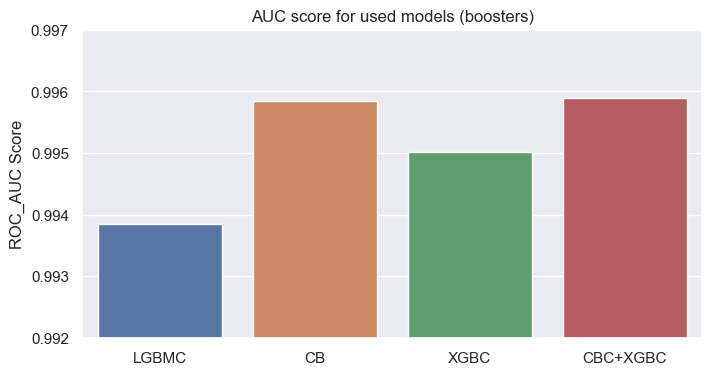

In [28]:
%matplotlib inline
sns.set(rc={'figure.figsize':(8, 4)})
sns.barplot(x='model', y='test_auc_score', data=stat, palette='deep')
plt.title('AUC score for used models (boosters)')
plt.ylim([0.992, 0.997])
plt.ylabel('ROC_AUC Score')
plt.xlabel('')
plt.show()

In [33]:
prepareit = Pipeline(steps=[("preprocessor",preprocessor)
                        ])
Xtrain_p = prepareit.fit_transform(Xtrain)
Xtest_p = prepareit.fit_transform(Xtest)
CBC = CatBoostClassifier(iterations=1000, eval_metric='AUC',use_best_model=True,random_seed=42)
CBC.fit(Xtrain_p, ytrain, eval_set=[(Xtest_p, ytest)], early_stopping_rounds=10)

Learning rate set to 0.218738
0:	test: 0.7816639	best: 0.7816639 (0)	total: 356ms	remaining: 5m 55s
1:	test: 0.8368156	best: 0.8368156 (1)	total: 713ms	remaining: 5m 55s
2:	test: 0.8690551	best: 0.8690551 (2)	total: 1.11s	remaining: 6m 8s
3:	test: 0.8944330	best: 0.8944330 (3)	total: 1.51s	remaining: 6m 15s
4:	test: 0.9209558	best: 0.9209558 (4)	total: 1.91s	remaining: 6m 20s
5:	test: 0.9308643	best: 0.9308643 (5)	total: 2.31s	remaining: 6m 22s
6:	test: 0.9466937	best: 0.9466937 (6)	total: 2.73s	remaining: 6m 26s
7:	test: 0.9504050	best: 0.9504050 (7)	total: 3.17s	remaining: 6m 33s
8:	test: 0.9635833	best: 0.9635833 (8)	total: 3.65s	remaining: 6m 41s
9:	test: 0.9675516	best: 0.9675516 (9)	total: 4.1s	remaining: 6m 45s
10:	test: 0.9730584	best: 0.9730584 (10)	total: 4.6s	remaining: 6m 53s
11:	test: 0.9760959	best: 0.9760959 (11)	total: 5.04s	remaining: 6m 55s
12:	test: 0.9767680	best: 0.9767680 (12)	total: 5.5s	remaining: 6m 57s
13:	test: 0.9795826	best: 0.9795826 (13)	total: 5.97s	rema

Stacking
--------

In [14]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [15]:
estimators2 = [
    ('XGBC', XGBClassifier(random_state=42)),
    ('LGBMC', LGBMClassifier(random_state=42)),
    ('CBC', CatBoostClassifier(random_state=42))
]

clf2 = StackingClassifier(
    estimators=estimators2, final_estimator=LogisticRegression()
)

pipeline_clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf2)])

    

In [ ]:
pipeline_clf.fit(Xtrain, ytrain)


In [17]:
predtrain = pipeline_clf.predict_proba(Xtrain)
predtest = pipeline_clf.predict_proba(Xtest)
print(f'auc scores \non train sample: {roc_auc_score(ytrain, predtrain[:,1])}\non test sample: {roc_auc_score(ytest, predtest[:,1])}')

auc scores 
on train sample: 0.9959252446288887
on test sample: 0.9956746290942676


Saving submissions
-------------

In [21]:
val = pd.read_csv('test.csv')


In [ ]:
val1 = prepareit(val)
CBC_final_predict_hard = CBC.predict(val1)

In [39]:
val = data_prepatation(val)
CBC_final_predict_hard1 = mod_CBC.predict(val)

In [43]:
SUB = pd.read_csv('sample_submission.csv')
SUB['class'] = CBC_final_predict_hard1
SUB['class'] = SUB['class'].apply(lambda x: 'e' if x == 0 else 'p')

In [52]:
SUB2 = SUB.copy()
SUB2['class'] = CBC_final_predict_hard
SUB2['class'] = SUB2['class'].apply(lambda x: 'e' if x == 0 else 'p')

In [58]:
SUB.to_csv('SUB1.csv', index=False)
SUB2.to_csv('SUB2.csv', index=False)

In [22]:
val2 = data_prepatation(val)
Stack_classifier_predict = pipeline_clf.predict(val)
SUB3 = pd.read_csv('sample_submission.csv')
SUB3['class'] = Stack_classifier_predict
SUB3['class'] = SUB3['class'].apply(lambda x: 'e' if x == 0 else 'p')
SUB3.to_csv('SUB3.csv', index=False)

In [26]:
test_predict  = mod_CBC.predict_proba(val2)

In [31]:
SUB4 = pd.read_csv('sample_submission.csv')
SUB4['class'] = test_predict[:,1]

Experiments with probability threshholds
---------------

In [36]:
SUB4_1_04 = SUB4.copy()
SUB4_1_04['class'] = SUB4_1_04['class'].apply(lambda x: 1 if x >= 0.4 else 0)
SUB4_1_04['class'] = SUB4_1_04['class'].apply(lambda x: 'e' if x == 0 else 'p')
SUB4_1_04.to_csv('SUB4_1_04.csv', index=False)

SUB4_1_045 = SUB4.copy()
SUB4_1_045['class'] = SUB4_1_045['class'].apply(lambda x: 1 if x >= 0.45 else 0)
SUB4_1_045['class'] = SUB4_1_045['class'].apply(lambda x: 'e' if x == 0 else 'p')
SUB4_1_045.to_csv('SUB4_1_045.csv', index=False)

SUB4_1_035 = SUB4.copy()
SUB4_1_035['class'] = SUB4_1_035['class'].apply(lambda x: 1 if x >= 0.35 else 0)
SUB4_1_035['class'] = SUB4_1_035['class'].apply(lambda x: 'e' if x == 0 else 'p')
SUB4_1_035.to_csv('SUB4_1_035.csv', index=False)

In [37]:
SUB4_1_055 = SUB4.copy()
SUB4_1_055['class'] = SUB4_1_055['class'].apply(lambda x: 1 if x >= 0.55 else 0)
SUB4_1_055['class'] = SUB4_1_055['class'].apply(lambda x: 'e' if x == 0 else 'p')
SUB4_1_055.to_csv('SUB4_1_055.csv', index=False)

In [38]:
SUB4_1_06 = SUB4.copy()
SUB4_1_06['class'] = SUB4_1_06['class'].apply(lambda x: 1 if x >= 0.6 else 0)
SUB4_1_06['class'] = SUB4_1_06['class'].apply(lambda x: 'e' if x == 0 else 'p')
SUB4_1_06.to_csv('SUB4_1_06.csv', index=False)

Optuna gave nothing here:
------------------------

In [ ]:
def objective_LGBMClassifier(trial):
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'n_estimators': trial.suggest_int('n_estimators', 5, 250),
        'reg_alpha': trial.suggest_int('reg_alpha', 10, 70),
        'reg_lambda': trial.suggest_int('reg_lambda', 20, 200),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    
    model = Pipeline(steps=[("preprocessor",preprocessor),
                            ("classifier", LGBMClassifier(random_state=42, force_col_wise=True,
                          **params))
                        ])
    model.fit(Xtrain, ytrain)
    preds = model.predict_proba(Xtest)

    return roc_auc_score(ytest,preds[:,1])

study_LGBMClassifier = optuna.create_study(direction='maximize', pruner='MedianPruner')
study_LGBMClassifier.optimize(objective_LGBMClassifier, n_trials=50)
print('Best one:', study_LGBMClassifier.best_trial.params, study_LGBMClassifier.best_value)
os.system(f'telegram-send "study_LGBMClassifier best score:{study_LGBMClassifier.best_value}"')

Best one: {'max_depth': 59, 'n_estimators': 242, 'reg_alpha': 27, 'reg_lambda': 127, 'min_child_weight': 8, 'colsample_bytree': 0.7636587433372971} 0.9952122105606247

In [ ]:
def objective_CBC(trial):
    
    params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.001,0.01,0.1,0.5]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"])
    }
    model = Pipeline(steps=[("preprocessor",preprocessor),
                            ("classifier", CatBoostClassifier(eval_metric='AUC', **params, iterations=100, early_stopping_rounds=10))
                        ])    
    model.fit(Xtrain, ytrain)
    preds = model.predict_proba(Xtest)

    return roc_auc_score(ytest,preds[:,1])

study_CBC = optuna.create_study(direction="maximize")
study_CBC.optimize(objective_CBC, n_trials=50, timeout=600)

Trial 7 finished with value: 0.9250973533185726 and parameters: {'learning_rate': 0.001, 'colsample_bylevel': 0.02000949060941635, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.9918769143244803